<h1><b>Match Prediction Considering Agent

<h2><b>Imports

In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from pprint import pprint

<h2><b>Reading Dataset

In [427]:
file = open('/content/valo_dataset.pkl', 'rb')
valo_df = pickle.load(file)
file.close()

In [428]:
valo_df.drop(['index'], axis = 1, inplace = True)
valo_df.drop_duplicates(keep = False, inplace = True)
valo_df.dropna(inplace = True)

<h2><b>Data Preprocessing and EDA

In [429]:
unique_agents = ['jett', 'killjoy', 'reyna', 'omen', 'raze', 'sova', 'skye', 'cypher', 'brimstone', 'astra', 'breach', 'chamber', 'sage', 'fade', 'viper', 'phoenix', 'kayo', 'yoru', 'deadlock', 'harbor', 'gekko', 'neon']
unique_maps = ['Split', 'Pearl', 'Lotus', 'Haven', 'Fracture', 'Ascent', 'Bind', 'Icebox']
unique_outcome = ['Victory', 'Defeat']

In [430]:
valo_df.head()

,map,A_player_1_agent,A_player_1_KD,A_player_1_Econ,A_player_1_avg_score,A_player_2_agent,A_player_2_KD,A_player_2_Econ,A_player_2_avg_score,A_player_3_agent,...,B_player_3_avg_score,B_player_4_agent,B_player_4_KD,B_player_4_Econ,B_player_4_avg_score,B_player_5_agent,B_player_5_KD,B_player_5_Econ,B_player_5_avg_score,A_outcome
0,Lotus,breach,0.87,52.0,187.0,brimstone,2.17,96.0,347.0,fade,...,215.0,omen,0.81,65.0,185.0,harbor,0.44,28.0,128.0,Victory
1,Haven,sova,0.73,49.0,183.0,kayo,1.07,67.0,237.0,astra,...,228.0,sova,1.18,54.0,197.0,breach,1.33,47.0,156.0,Defeat
2,Ascent,kayo,2.43,89.0,252.0,killjoy,2.10,99.0,315.0,jett,...,121.0,killjoy,0.40,29.0,116.0,jett,0.27,18.0,60.0,Victory
3,Icebox,sova,2.67,87.0,330.0,jett,1.14,62.0,241.0,killjoy,...,196.0,jett,0.60,40.0,146.0,reyna,0.44,26.0,108.0,Victory
4,Fracture,brimstone,1.91,84.0,304.0,raze,2.33,85.0,286.0,reyna,...,165.0,brimstone,0.59,43.0,154.0,killjoy,0.33,34.0,112.0,Victory


In [431]:
X = valo_df.drop(['A_outcome'], axis = 1)
y = valo_df[['A_outcome']]

In [432]:
y = pd.DataFrame(y, columns = ['A_outcome'])
y.head(5)

,A_outcome
0,Victory
1,Defeat
2,Victory
3,Victory
4,Victory


In [433]:
valo_agent_col = ['A_player_1_agent',
               'A_player_2_agent',
               'A_player_3_agent',
               'A_player_4_agent',
               'A_player_5_agent',
               'B_player_1_agent',
               'B_player_2_agent',
               'B_player_3_agent',
               'B_player_4_agent',
               'B_player_5_agent']

valo_agent_col_index = []
all_col = list(X.columns)
for col in valo_agent_col:
    valo_agent_col_index.append(all_col.index(col))
valo_agent_col_index

[1, 5, 9, 13, 17, 21, 25, 29, 33, 37]

In [434]:
# Using column transformer on dataset
from sklearn.compose import ColumnTransformer

# out_transform -> one hot encoding of outcome of match
out_transform = ColumnTransformer(transformers = [
    ('out_trf', OneHotEncoder(sparse = False, drop = 'first'), [0])
], remainder = 'passthrough')

# transformer_1 -> trf1 -> Ordinal Encoding of unique maps in dataset
#                  trf2 -> Ordinal Encoding of unique Valorant Agents of each player
transformer_1 = ColumnTransformer(transformers = [
    ('trf1', OrdinalEncoder(categories = [unique_maps]), [0]),
    ('trf3', OrdinalEncoder(categories = [unique_agents for i in range(len(valo_agent_col_index))]), valo_agent_col_index)
], remainder = 'passthrough')

In [435]:
# fit_transform
transformed_valo_array = transformer_1.fit_transform(X)
y = out_transform.fit_transform(y)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [436]:
transformed_valo_array

array([[  2.  ,  10.  ,   8.  , ...,   0.44,  28.  , 128.  ],
       [  3.  ,   5.  ,  16.  , ...,   1.33,  47.  , 156.  ],
       [  5.  ,  16.  ,   1.  , ...,   0.27,  18.  ,  60.  ],
       ...,
       [  6.  ,   7.  ,   5.  , ...,   0.53,  37.  , 129.  ],
       [  0.  ,   7.  ,   4.  , ...,   0.53,  60.  , 163.  ],
       [  1.  ,   7.  ,   6.  , ...,   0.4 ,  29.  , 107.  ]])

In [437]:
y = pd.DataFrame(y, columns = ['A_outcome'])
y.head(5)

,A_outcome
0,1.0
1,0.0
2,1.0
3,1.0
4,1.0


In [438]:
# numpy array of transformed cols to dataframe
all_col = list(X.columns)
transformed_col = ['map'] + valo_agent_col
for col in transformed_col:
    all_col.remove(col)
final_col = transformed_col + all_col
transformed_valo = pd.DataFrame(transformed_valo_array, columns = final_col)

In [439]:
transformed_valo.head(5)

,map,A_player_1_agent,A_player_2_agent,A_player_3_agent,A_player_4_agent,A_player_5_agent,B_player_1_agent,B_player_2_agent,B_player_3_agent,B_player_4_agent,...,B_player_2_avg_score,B_player_3_KD,B_player_3_Econ,B_player_3_avg_score,B_player_4_KD,B_player_4_Econ,B_player_4_avg_score,B_player_5_KD,B_player_5_Econ,B_player_5_avg_score
0,2.0,10.0,8.0,13.0,0.0,11.0,0.0,17.0,2.0,3.0,...,244.0,1.00,61.0,215.0,0.81,65.0,185.0,0.44,28.0,128.0
1,3.0,5.0,16.0,9.0,1.0,0.0,0.0,3.0,1.0,5.0,...,243.0,1.33,55.0,228.0,1.18,54.0,197.0,1.33,47.0,156.0
2,5.0,16.0,1.0,0.0,8.0,5.0,16.0,5.0,3.0,1.0,...,221.0,0.44,34.0,121.0,0.40,29.0,116.0,0.27,18.0,60.0
3,7.0,5.0,0.0,1.0,19.0,14.0,1.0,14.0,5.0,0.0,...,225.0,0.92,65.0,196.0,0.60,40.0,146.0,0.44,26.0,108.0
4,4.0,8.0,4.0,2.0,1.0,10.0,0.0,14.0,10.0,8.0,...,188.0,0.62,46.0,165.0,0.59,43.0,154.0,0.33,34.0,112.0


In [440]:
X = transformed_valo

In [441]:
for col in list(transformed_valo.columns):
    transformed_valo[col] = transformed_valo[col].astype('float')

<h3>Cross Validation

In [442]:
def cross_validation(model, X, y, cv = 5):
    scoring = ['f1', 'accuracy']
    results = cross_validate(estimator = model, X = X, y = y, cv = cv, scoring = scoring, return_train_score=True)
    return {"Training accuracy scores": results['train_accuracy'],
              "Mean Training accuracy": results['train_accuracy'].mean(),
              "Training f1 scores": results['train_f1'],
              "Mean Training f1": results['train_f1'].mean(),
              "Validation accuracy scores": results['test_accuracy'],
              "Mean Validation accuracy": results['test_accuracy'].mean(),
              "Validation f1 scores": results['test_f1'],
              "Mean Validation f1": results['test_f1'].mean(),
              }

<h2><b>Model Building

<h3><b>LogisticRegression

In [443]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [444]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression(solver = 'liblinear')
LR_result = cross_validation(LR_model, X_scaled, y.iloc[:, 0], 10)
print(LR_result['Mean Training accuracy'], LR_result['Mean Training f1'], LR_result['Mean Validation accuracy'], LR_result['Mean Validation f1'])

0.9249505395207389 0.9344664138342168 0.9206272892262003 0.930570959133101


In [445]:
LR_model.fit(X_scaled, y.iloc[:, 0])
f_imp_LR = LR_model.coef_[0]

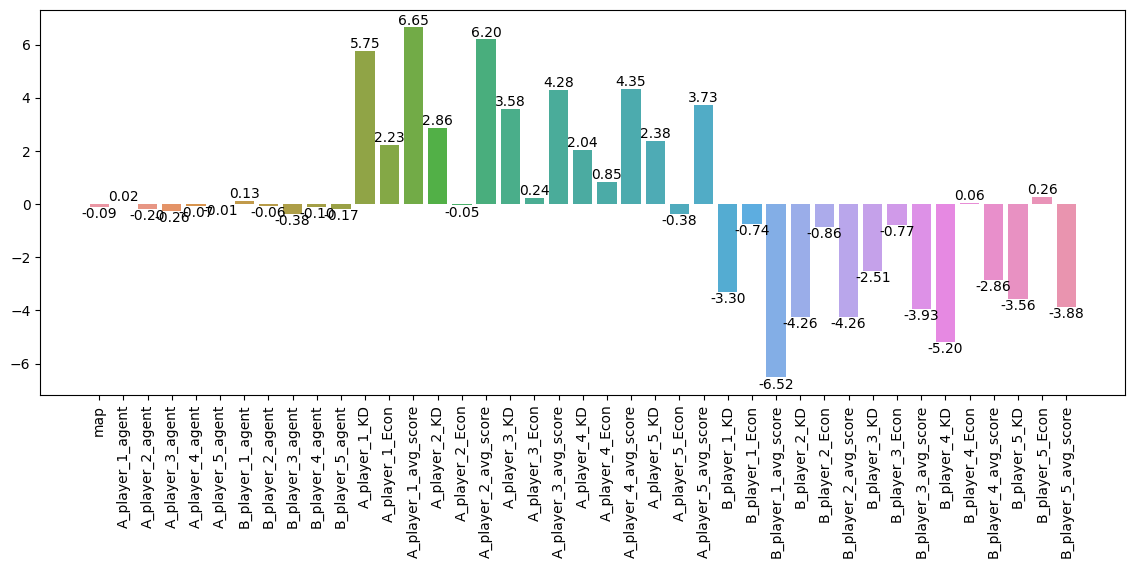

In [24]:
# Feature Importance
plt.figure(figsize = (14, 5))
ax = sns.barplot(x = list(X.columns), y = f_imp_LR)
plt.xticks(rotation = 90)
plt.plot()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

<h3><b>SVC

In [25]:
from sklearn.svm import SVC
SVC_model = SVC(kernel='linear')
SVC_result = cross_validation(SVC_model, X_scaled, y.iloc[:, 0], 10)
print(SVC_result['Mean Training accuracy'], SVC_result['Mean Training f1'], SVC_result['Mean Validation accuracy'], SVC_result['Mean Validation f1'])

0.9276950423056907 0.9366726152481786 0.9246229995050322 0.9338483651392631


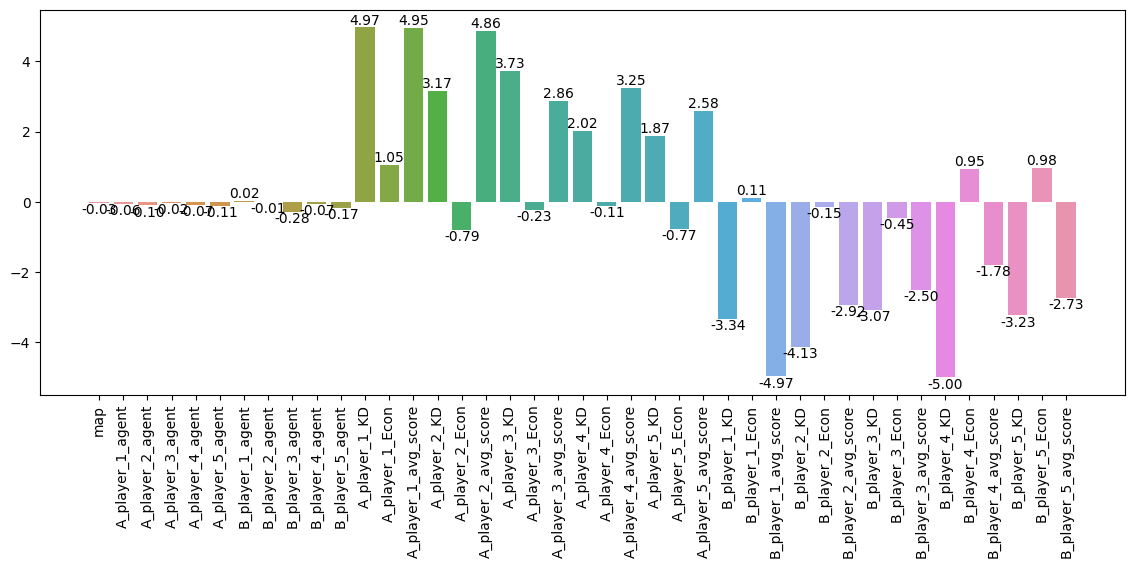

In [26]:
# Feature Importance
SVC_model.fit(X_scaled, y.iloc[:, 0])
f_imp_SVC = SVC_model.coef_[0]
plt.figure(figsize = (14, 5))
ax = sns.barplot(x = list(X.columns), y = f_imp_SVC)
plt.xticks(rotation = 90)
plt.plot()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

<h2><b>PCA

In [200]:
X.head()

,map,A_player_1_agent,A_player_2_agent,A_player_3_agent,A_player_4_agent,A_player_5_agent,B_player_1_agent,B_player_2_agent,B_player_3_agent,B_player_4_agent,...,B_player_2_avg_score,B_player_3_KD,B_player_3_Econ,B_player_3_avg_score,B_player_4_KD,B_player_4_Econ,B_player_4_avg_score,B_player_5_KD,B_player_5_Econ,B_player_5_avg_score
0,2.0,10.0,8.0,13.0,0.0,11.0,0.0,17.0,2.0,3.0,...,244.0,1.00,61.0,215.0,0.81,65.0,185.0,0.44,28.0,128.0
1,3.0,5.0,16.0,9.0,1.0,0.0,0.0,3.0,1.0,5.0,...,243.0,1.33,55.0,228.0,1.18,54.0,197.0,1.33,47.0,156.0
2,5.0,16.0,1.0,0.0,8.0,5.0,16.0,5.0,3.0,1.0,...,221.0,0.44,34.0,121.0,0.40,29.0,116.0,0.27,18.0,60.0
3,7.0,5.0,0.0,1.0,19.0,14.0,1.0,14.0,5.0,0.0,...,225.0,0.92,65.0,196.0,0.60,40.0,146.0,0.44,26.0,108.0
4,4.0,8.0,4.0,2.0,1.0,10.0,0.0,14.0,10.0,8.0,...,188.0,0.62,46.0,165.0,0.59,43.0,154.0,0.33,34.0,112.0


In [202]:
# Using Column Transformer for applying PCA
from sklearn.decomposition import PCA

A_KD_col = ['A_player_1_KD', 'A_player_2_KD', 'A_player_3_KD', 'A_player_4_KD', 'A_player_5_KD']
B_KD_col = ['B_player_1_KD', 'B_player_2_KD', 'B_player_3_KD', 'B_player_4_KD', 'B_player_5_KD']

A_agent_col = ['A_player_1_agent', 'A_player_2_agent', 'A_player_3_agent', 'A_player_4_agent', 'A_player_5_agent']
A_agent_col_index = []
all_col = list(X.columns)
for col in A_agent_col:
    A_agent_col_index.append(all_col.index(col))

A_Econ_col = ['A_player_1_Econ', 'A_player_2_Econ', 'A_player_3_Econ', 'A_player_4_Econ', 'A_player_5_Econ']
A_Econ_col_index = []
all_col = list(X.columns)
for col in A_Econ_col:
    A_Econ_col_index.append(all_col.index(col))

A_avg_score_col = ['A_player_1_avg_score', 'A_player_2_avg_score', 'A_player_3_avg_score', 'A_player_4_avg_score', 'A_player_5_avg_score']
A_avg_score_col_index = []
all_col = list(X.columns)
for col in A_avg_score_col:
    A_avg_score_col_index.append(all_col.index(col))

B_agent_col = ['B_player_1_agent', 'B_player_2_agent', 'B_player_3_agent', 'B_player_4_agent', 'B_player_5_agent']
B_agent_col_index = []
all_col = list(X.columns)
for col in B_agent_col:
    B_agent_col_index.append(all_col.index(col))

B_Econ_col = ['B_player_1_Econ', 'B_player_2_Econ', 'B_player_3_Econ', 'B_player_4_Econ', 'B_player_5_Econ']
B_Econ_col_index = []
all_col = list(X.columns)
for col in B_Econ_col:
    B_Econ_col_index.append(all_col.index(col))

B_avg_score_col = ['B_player_1_avg_score', 'B_player_2_avg_score', 'B_player_3_avg_score', 'B_player_4_avg_score', 'B_player_5_avg_score']
B_avg_score_col_index = []
all_col = list(X.columns)
for col in B_avg_score_col:
    B_avg_score_col_index.append(all_col.index(col))


transformer_2 = ColumnTransformer(transformers = [
    ('pca1', PCA(n_components=1, copy = False), A_agent_col_index),
    ('pca2', PCA(n_components=1, copy = False), A_Econ_col_index),
    ('pca3', PCA(n_components=1, copy = False), A_avg_score_col_index),
    ('pca4', PCA(n_components=1, copy = False), B_agent_col_index),
    ('pca5', PCA(n_components=1, copy = False), B_Econ_col_index),
    ('pca6', PCA(n_components=1, copy = False), B_avg_score_col_index)
], remainder = 'passthrough')

X_dr = transformer_2.fit_transform(X)

In [203]:
X_dr[0]

array([ -1.81730737,  12.41073719, -71.76691881,  10.45585791,
         2.00073006,   3.6955363 ,   2.        ,   0.87      ,
         2.17      ,   1.19      ,   1.        ,   0.81      ,
         1.05      ,   1.        ,   1.        ,   0.81      ,
         0.44      ])

In [204]:
X_dr = pd.DataFrame(X_dr, columns = ['A_agent_dr', 'A_Econ_dr', 'A_avg_score_dr', 'B_agent_dr', 'B_Econ_dr', 'B_avg_score_dr'] + ['map'] + A_KD_col + B_KD_col)
transformer_3 = ColumnTransformer(transformers = [
    ('min_max_scalar', MinMaxScaler(), slice(0, X_dr.shape[1]+1))
], remainder = 'passthrough')
X_dr_scaled = transformer_3.fit_transform(X_dr)

In [205]:
# Scaling
X_dr_scaled_df = pd.DataFrame(X_dr_scaled, columns = ['A_agent_dr', 'A_Econ_dr', 'A_avg_score_dr', 'B_agent_dr', 'B_Econ_dr', 'B_avg_score_dr'] + ['map'] + A_KD_col + B_KD_col)

In [206]:
X_dr_scaled_df.head()

,A_agent_dr,A_Econ_dr,A_avg_score_dr,B_agent_dr,B_Econ_dr,B_avg_score_dr,map,A_player_1_KD,A_player_2_KD,A_player_3_KD,A_player_4_KD,A_player_5_KD,B_player_1_KD,B_player_2_KD,B_player_3_KD,B_player_4_KD,B_player_5_KD
0,0.414998,0.102838,0.244572,0.805301,0.070893,0.441690,0.285714,0.10875,0.123634,0.118510,0.066092,0.162,0.038581,0.096774,0.057971,0.173448,0.088
1,0.302419,0.064493,0.315604,0.487031,0.066195,0.402852,0.428571,0.09125,0.048497,0.081264,0.034483,0.094,0.059116,0.187097,0.081884,0.252677,0.266
2,0.843413,0.145754,0.352419,0.396638,0.024429,0.660735,0.714286,0.30375,0.118852,0.142212,0.079023,0.250,0.035470,0.087742,0.017391,0.085653,0.054
3,0.588967,0.081077,0.513961,0.789632,0.053160,0.560839,1.000000,0.33375,0.053279,0.097065,0.073276,0.200,0.027380,0.096774,0.052174,0.128480,0.088
4,0.539084,0.105784,0.432674,0.757191,0.038233,0.614182,0.571429,0.23875,0.134563,0.247178,0.051006,0.160,0.039826,0.056774,0.030435,0.126338,0.066


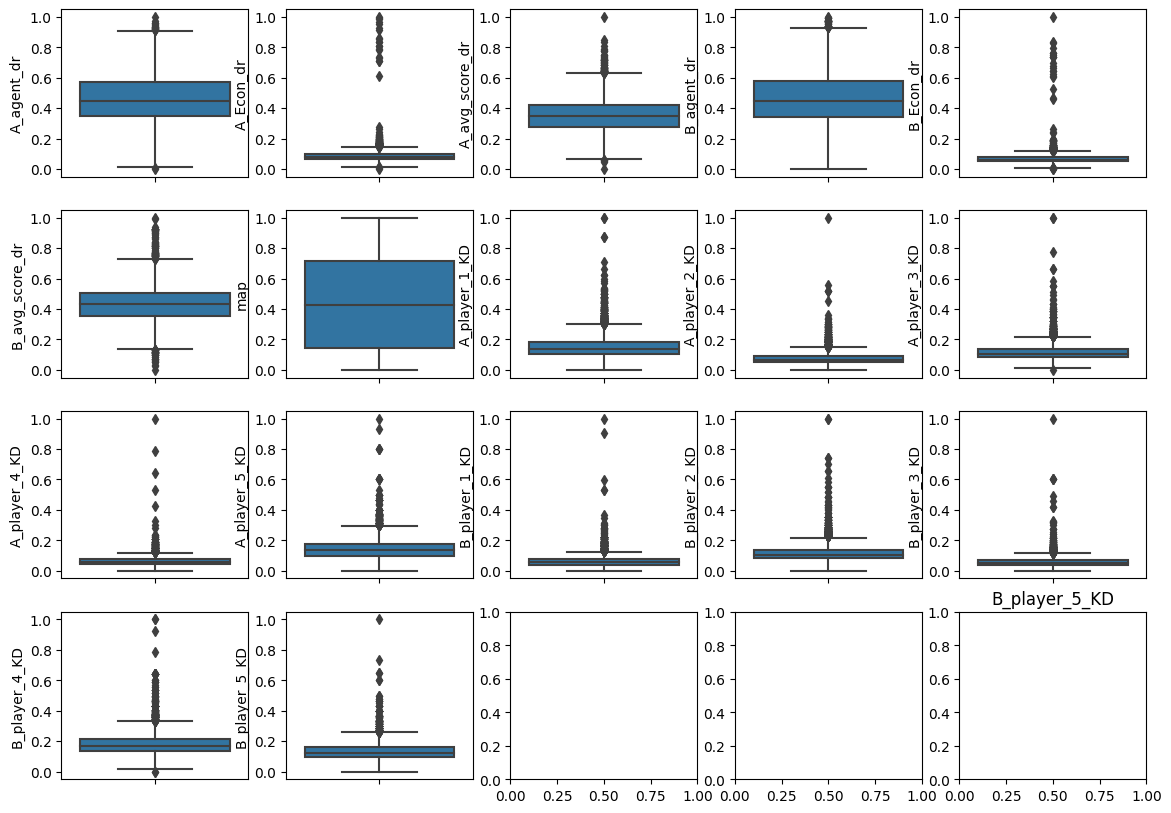

In [34]:
# BoxPlot for outliers detection
fig, axis = plt.subplots(nrows = 4, ncols = 5, figsize = (14, 10))
axis = axis.flatten()
for i, col in enumerate(list(X_dr_scaled_df.columns)):
    sns.boxplot(y = X_dr_scaled_df[col], ax = axis[i])
    plt.title(col)

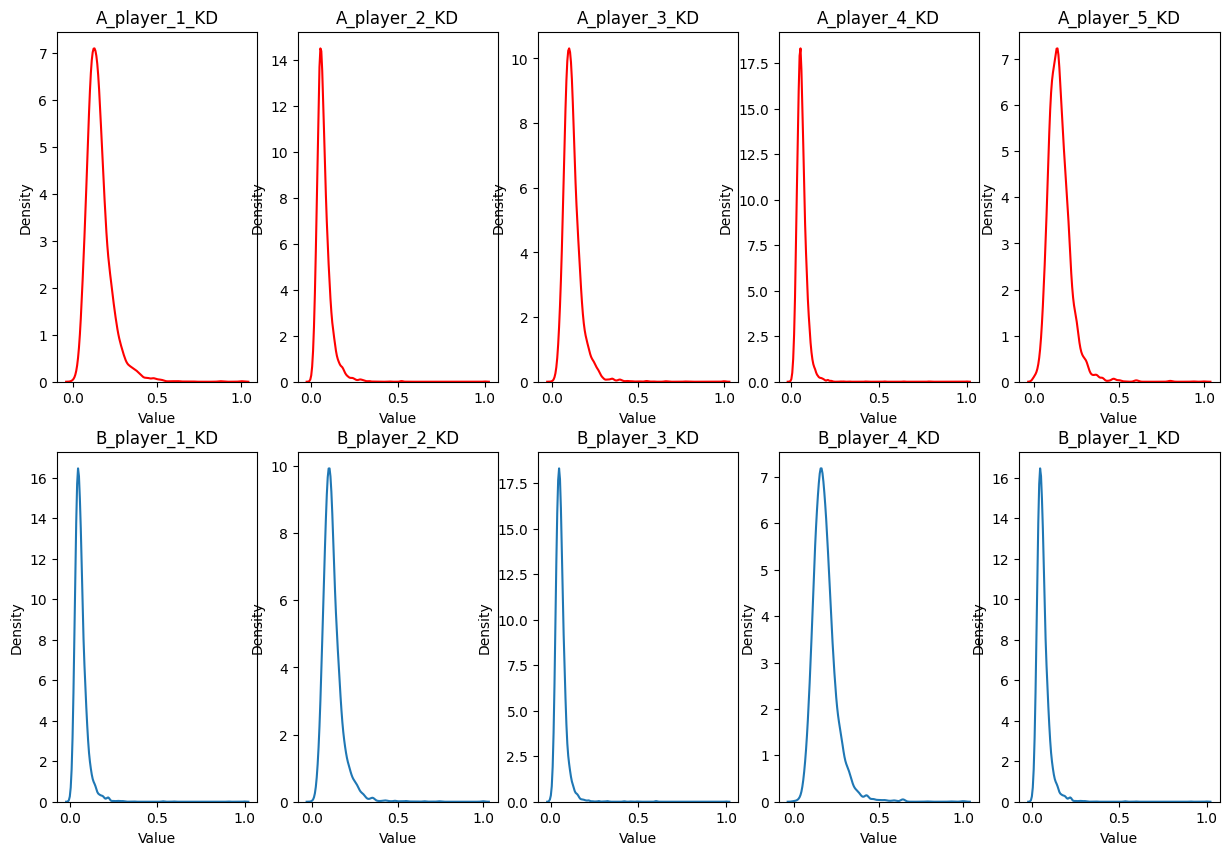

In [114]:
# KDE plot of each player's KD ratio
fig, axis = plt.subplots(nrows = 2, ncols = 5, figsize = (15, 10))
axis = axis.flatten()
for i in range(5):
    sns.kdeplot(data = X_dr_scaled_df[f'A_player_{i+1}_KD'], ax = axis[i], label = f'A_player_{i+1}_KD', color = 'red')
    axis[i].set_xlabel('Value')
    axis[i].set_title(f'A_player_{i+1}_KD')

for i in range(5, 10):
    sns.kdeplot(data = X_dr_scaled_df[f'B_player_{(i+1)%5 if (i+1)%5 != 0 else 1}_KD'], ax = axis[i], label = f'B_player_{(i+1)%5 if (i+1)%5 != 0 else 1}_KD')
    axis[i].set_xlabel('Value')
    axis[i].set_title(f'B_player_{(i+1)%5 if (i+1)%5 != 0 else 1}_KD')

plt.show()

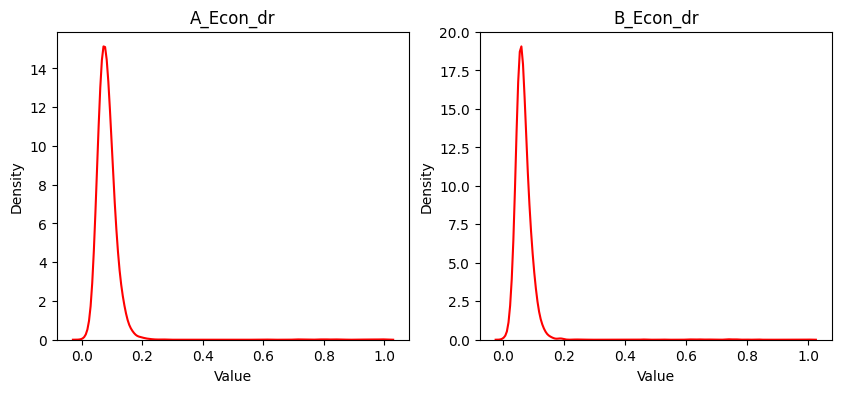

In [115]:
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
axis = axis.flatten()
sns.kdeplot(data = X_dr_scaled_df['A_Econ_dr'], ax = axis[0], label = 'A_Econ_dr', color = 'red')
axis[0].set_xlabel('Value')
axis[0].set_title('A_Econ_dr')
sns.kdeplot(data = X_dr_scaled_df['B_Econ_dr'], ax = axis[1], label = 'B_Econ_dr', color = 'red')
axis[1].set_xlabel('Value')
axis[1].set_title('B_Econ_dr')
plt.show()

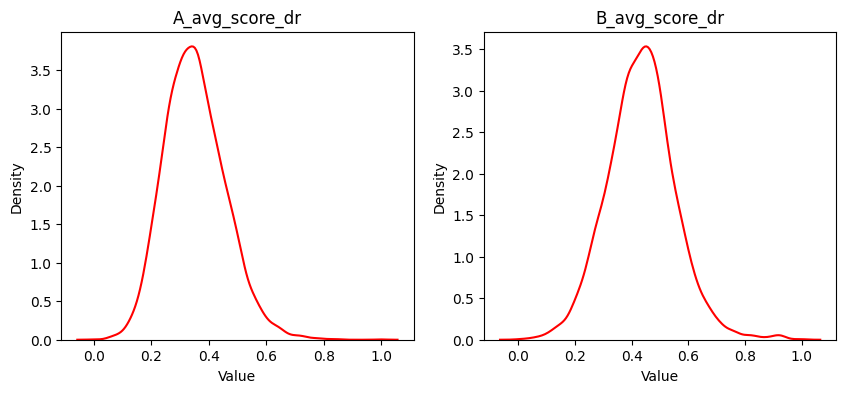

In [ ]:
fig, axis = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
axis = axis.flatten()
sns.kdeplot(data = X_dr_scaled_df['A_avg_score_dr'], ax = axis[0], label = 'A_avg_score_dr', color = 'red')
axis[0].set_xlabel('Value')
axis[0].set_title('A_avg_score_dr')
sns.kdeplot(data = X_dr_scaled_df['B_avg_score_dr'], ax = axis[1], label = 'B_avg_score_dr', color = 'red')
axis[1].set_xlabel('Value')
axis[1].set_title('B_avg_score_dr')
plt.show()

In [207]:
print(len(X_dr_scaled_df[X_dr_scaled_df['A_avg_score_dr']>0.8]),
len(X_dr_scaled_df[X_dr_scaled_df['B_avg_score_dr']>0.8]))

4 42


In [208]:
X_dr_scaled_df.shape

(5506, 17)

In [209]:
# Removing outliers
for i in range(1, 6):
    y = y.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'A_player_{i}_KD']>0.5].index), axis = 0)
    X_dr_scaled_df.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'A_player_{i}_KD']>0.5].index), axis = 0, inplace = True)

for i in range(1, 6):
    y = y.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'B_player_{i}_KD']>0.5].index), axis = 0)
    X_dr_scaled_df.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'B_player_{i}_KD']>0.5].index), axis = 0, inplace = True)

y = y.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'A_Econ_dr']>0.2].index), axis = 0)
X_dr_scaled_df.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'A_Econ_dr']>0.2].index), axis = 0, inplace = True)
y = y.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'B_Econ_dr']>0.2].index), axis = 0)
X_dr_scaled_df.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'B_Econ_dr']>0.2].index), axis = 0, inplace = True)

y = y.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'A_avg_score_dr']>0.8].index), axis = 0)
X_dr_scaled_df.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'A_avg_score_dr']>0.8].index), axis = 0, inplace = True)
y = y.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'B_avg_score_dr']>0.8].index), axis = 0)
X_dr_scaled_df.drop(list(X_dr_scaled_df[X_dr_scaled_df[f'B_avg_score_dr']>0.8].index), axis = 0, inplace = True)

In [210]:
X_dr_scaled_df.shape

(5374, 17)

In [211]:
y.shape

(5374, 1)

<h3><b>LR

In [41]:
LR_dr_model = LogisticRegression(solver = 'liblinear')
LR_dr_result = cross_validation(LR_dr_model, X_dr_scaled_df, y.iloc[:, 0], 10)
print(LR_dr_result['Mean Training accuracy'], LR_dr_result['Mean Training f1'], LR_dr_result['Mean Validation accuracy'], LR_dr_result['Mean Validation f1'])

0.9198611244349071 0.930620035862089 0.9203633707849612 0.9310697558823465


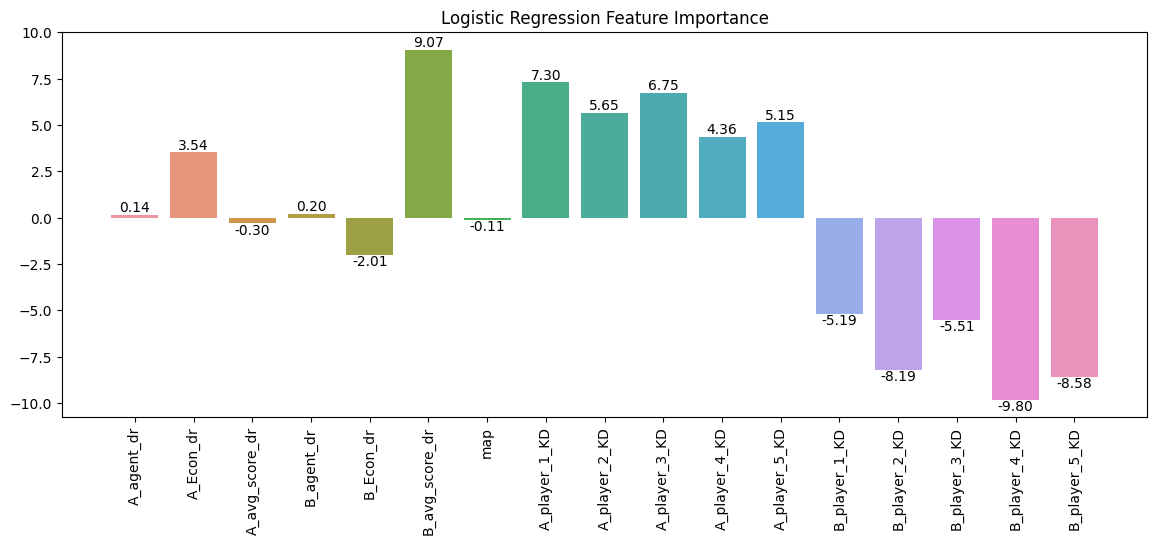

In [ ]:
# Feature Importance
LR_dr_model.fit(X_dr_scaled_df, y.iloc[:, 0])
f_imp_LR_dr = LR_dr_model.coef_[0]
plt.figure(figsize = (14, 5))
ax = sns.barplot(x = list(X_dr_scaled_df.columns), y = f_imp_LR_dr)
plt.xticks(rotation = 90)
plt.title("Logistic Regression Feature Importance")
plt.plot()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

<h3><b>SVC

In [ ]:
SVC_dr_model = SVC(kernel='linear', probability = True)
SVC_dr_result = cross_validation(SVC_dr_model, X_dr_scaled_df, y.iloc[:, 0], 10)
print(SVC_dr_result['Mean Training accuracy'], SVC_dr_result['Mean Training f1'], SVC_dr_result['Mean Validation accuracy'], SVC_dr_result['Mean Validation f1'])

0.9244924317703367 0.9343260566578193 0.9224086727170775 0.9326196914938005


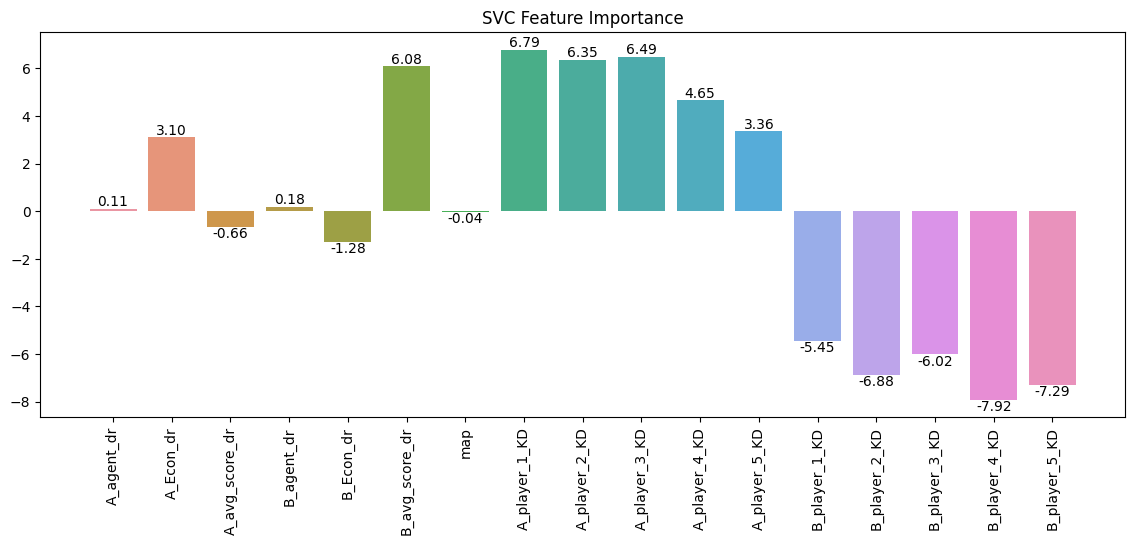

In [ ]:
# Feature Importance
SVC_dr_model.fit(X_dr_scaled_df, y.iloc[:, 0])
f_imp_SVC_dr = SVC_dr_model.coef_[0]
plt.figure(figsize = (14, 5))
ax = sns.barplot(x = list(X_dr_scaled_df.columns), y = f_imp_SVC_dr)
plt.xticks(rotation = 90)
plt.title("SVC Feature Importance")
plt.plot()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

<h3><b>LGB

In [ ]:
import lightgbm as lgb
LGB_dr_model = lgb.LGBMClassifier()
LGB_dr_result = cross_validation(LGB_dr_model, X_dr_scaled_df, y.iloc[:, 0], 10)
print(LGB_dr_result['Mean Training accuracy'], LGB_dr_result['Mean Training f1'], LGB_dr_result['Mean Validation accuracy'], LGB_dr_result['Mean Validation f1'])

0.9999586435070306 0.999963794351919 0.9315223636753822 0.9402638471812426


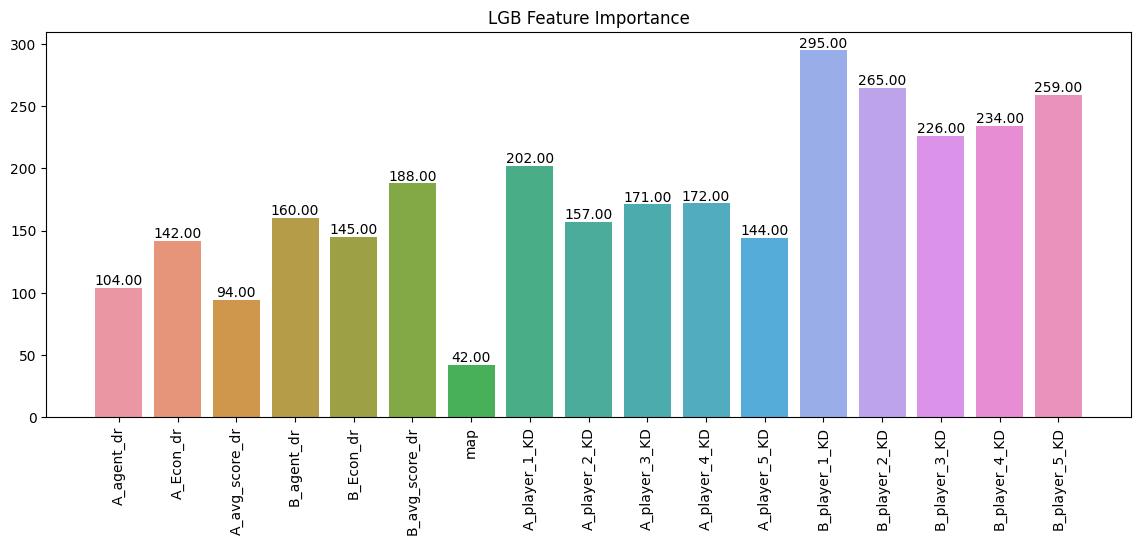

In [ ]:
# Feature Importance
LGB_dr_model.fit(X_dr_scaled_df, y.iloc[:, 0])
f_imp_LGB_dr = LGB_dr_model.feature_importances_
plt.figure(figsize = (14, 5))
ax = sns.barplot(x = list(X_dr_scaled_df.columns), y = f_imp_LGB_dr)
plt.xticks(rotation = 90)
plt.title("LGB Feature Importance")
plt.plot()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

<h3><b>XGB

In [ ]:
import xgboost as xgb
XGB_dr_model = xgb.XGBClassifier()
XGB_dr_result = cross_validation(XGB_dr_model, X_dr_scaled_df, y.iloc[:, 0], 10)
print(XGB_dr_result['Mean Training accuracy'], XGB_dr_result['Mean Training f1'], XGB_dr_result['Mean Validation accuracy'], XGB_dr_result['Mean Validation f1'])

1.0 1.0 0.9324517317051221 0.9410854590016273


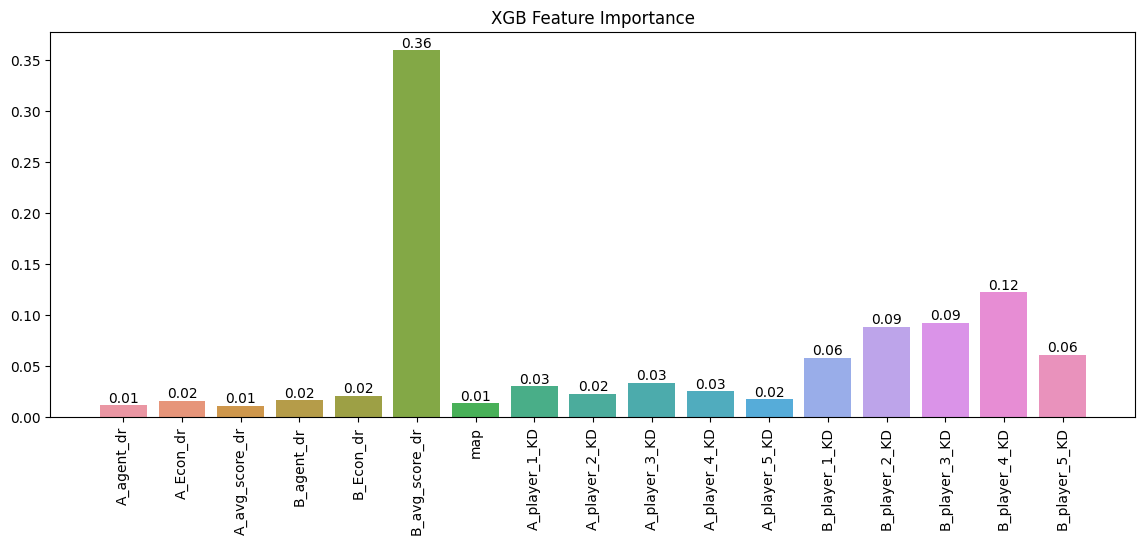

In [ ]:
# Feature Importance
XGB_dr_model.fit(X_dr_scaled_df, y.iloc[:, 0])
f_imp_XGB_dr = XGB_dr_model.feature_importances_
plt.figure(figsize = (14, 5))
ax = sns.barplot(x = list(X_dr_scaled_df.columns), y = f_imp_XGB_dr)
plt.xticks(rotation = 90)
plt.title("XGB Feature Importance")
plt.plot()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

<h3><b>CatBoost

In [ ]:
# Indtalling CatBoost
!pip install catboost

In [ ]:
import catboost as cb
CB_dr_model = cb.CatBoostClassifier(verbose=False)
CB_dr_result = cross_validation(CB_dr_model, X_dr_scaled_df, y.iloc[:, 0], 10)
print(CB_dr_result['Mean Training accuracy'], CB_dr_result['Mean Training f1'], CB_dr_result['Mean Validation accuracy'], CB_dr_result['Mean Validation f1'])

0.9943348957657347 0.9950450894733558 0.9317068527479526 0.9404160309667617


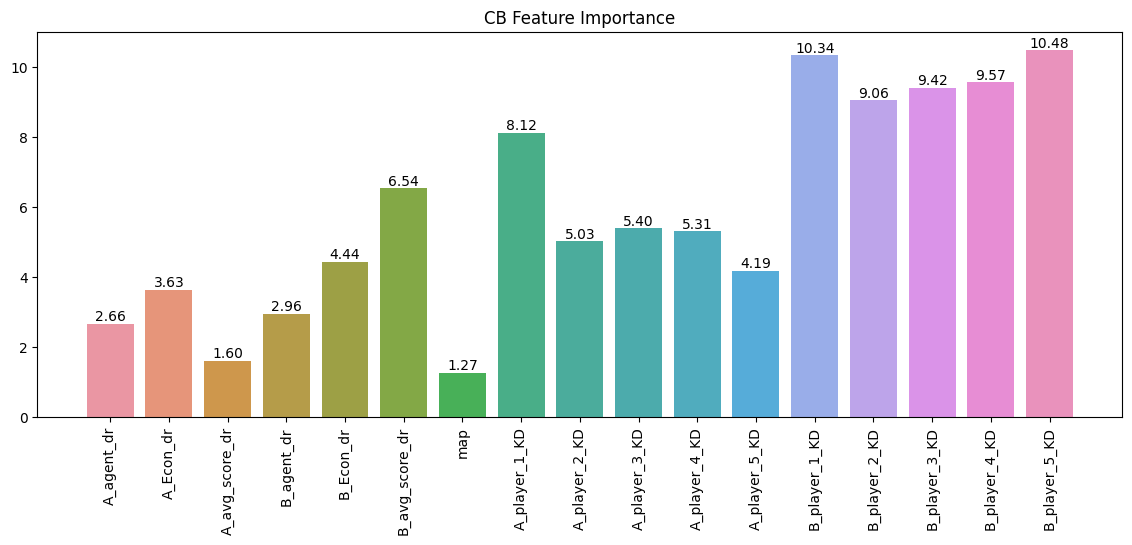

In [ ]:
# Feature Importance
CB_dr_model.fit(X_dr_scaled_df, y.iloc[:, 0])
f_imp_CB_dr = CB_dr_model.feature_importances_
plt.figure(figsize = (14, 5))
ax = sns.barplot(x = list(X_dr_scaled_df.columns), y = f_imp_CB_dr)
plt.xticks(rotation = 90)
plt.title("CB Feature Importance")
plt.plot()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

<h3><b>RFC

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFC_dr_model = RandomForestClassifier()
RFC_dr_result = cross_validation(RFC_dr_model, X_dr_scaled_df, y.iloc[:, 0], 10)
print(RFC_dr_result['Mean Training accuracy'], RFC_dr_result['Mean Training f1'], RFC_dr_result['Mean Validation accuracy'], RFC_dr_result['Mean Validation f1'])

0.9999586477820455 0.9999637812374939 0.9315206330086603 0.9401852190485283


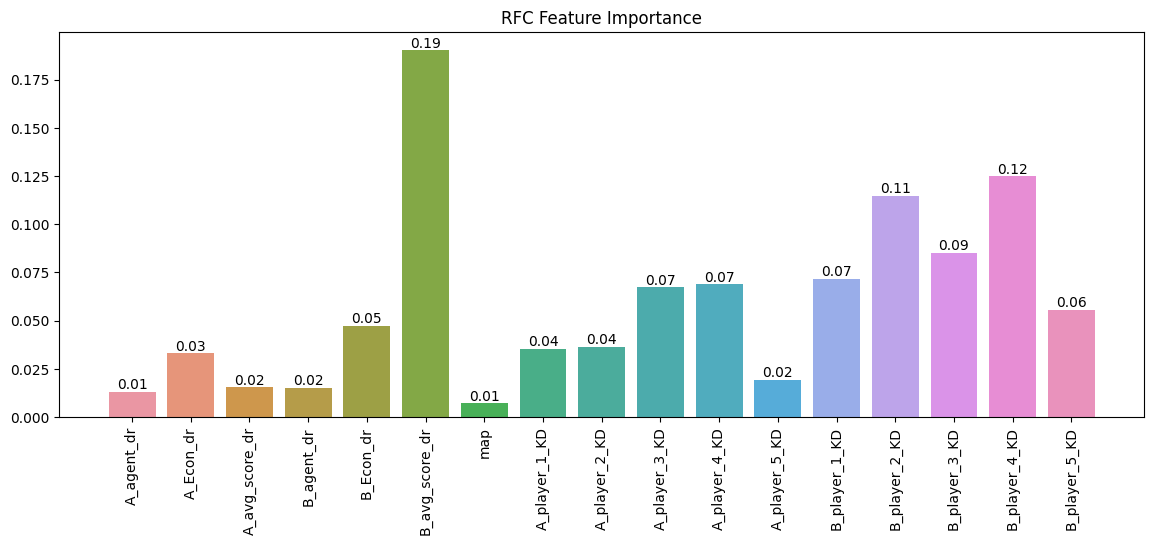

In [ ]:
# Feature Importance
RFC_dr_model.fit(X_dr_scaled_df, y.iloc[:, 0])
f_imp_RFC_dr = RFC_dr_model.feature_importances_
plt.figure(figsize = (14, 5))
ax = sns.barplot(x = list(X_dr_scaled_df.columns), y = f_imp_RFC_dr)
plt.xticks(rotation = 90)
plt.title("RFC Feature Importance")
plt.plot()
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

<h2><b>Ensembling Model

<h3>Multiple Algorithm Model Ensemble

In [ ]:
# hard voting classifier on LGB, XGB, RFC, CB, SVC, LR
from sklearn.ensemble import VotingClassifier
estimators = [('LGB', LGB_dr_model), ('XGB', XGB_dr_model), ('RFC', RFC_dr_model), ('CB', CB_dr_model), ('SVC', SVC_dr_model), ('LR', LR_dr_model)]
vc_model_hard = VotingClassifier(estimators = estimators, voting = 'hard')
vc_result_hard = cross_validation(vc_model_hard, X_dr_scaled_df, y.iloc[:, 0], 5)
print('Mean Validation accuracy:\t', vc_result_hard['Mean Validation accuracy'])

Mean Validation accuracy:	 0.9300331730977437


In [ ]:
estimators = [('LGB', LGB_dr_model), ('XGB', XGB_dr_model), ('RFC', RFC_dr_model), ('CB', CB_dr_model), ('SVC', SVC_dr_model), ('LR', LR_dr_model)]
vc_model_soft = VotingClassifier(estimators = estimators, voting = 'soft')
vc_result_soft = cross_validation(vc_model_soft, X_dr_scaled_df, y.iloc[:, 0], 5)
print('Mean Validation accuracy:\t', vc_result_soft['Mean Validation accuracy'])

Mean Validation accuracy:	 0.9309632324282188


In [42]:
# Train Test Split
from sklearn.model_selection import train_test_split
X = X_dr_scaled_df.drop(['map'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y.iloc[:, 0], test_size = 0.2, random_state = 3)

Train_Accuracy:	 0.9986043265875785


[]

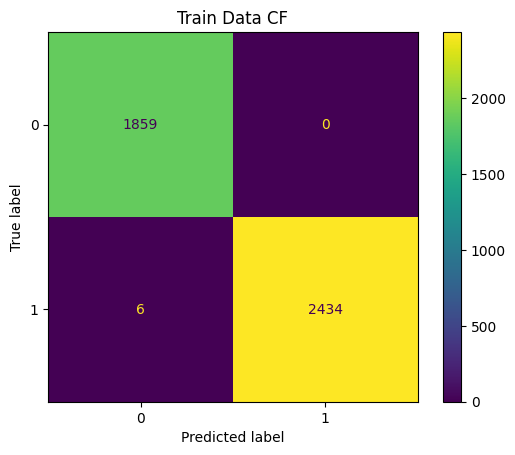

In [ ]:
# Confusion Matrix
vc_model_hard.fit(X_train, y_train)
vc_model_hard_pred = vc_model_hard.predict(X_test)
vc_model_hard_pred_train = vc_model_hard.predict(X_train)
print("Train_Accuracy:\t", accuracy_score(y_train, vc_model_hard_pred_train))
confusion_matrix_train = confusion_matrix(y_train, vc_model_hard_pred_train)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train)
cm_display.plot()
plt.title('Train Data CF')
plt.plot()

Test_Accuracy:	 0.9274418604651162


[]

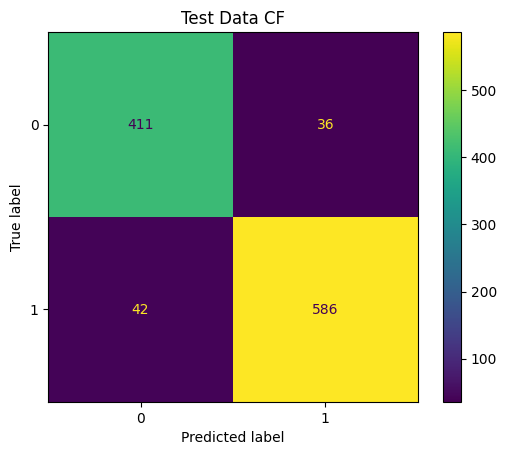

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, vc_model_hard_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test)
print("Test_Accuracy:\t", accuracy_score(y_test, vc_model_hard_pred))
cm_display.plot()
plt.title('Test Data CF')
plt.plot()

In [ ]:
# soft voting classifier on SVC with rbf kernel, LGB2, LGB3, LGB4, SVC with linear kernel and LR
mdl_1 = lgb.LGBMClassifier(n_estimators = 80, num_leaves = 31, max_depth = 6, min_split_gain = 0.8, reg_lambda = 15)
mdl_2 = lgb.LGBMClassifier(n_estimators = 80, num_leaves = 51, max_depth = 31, reg_lambda = 15)
mdl_3 = lgb.LGBMClassifier(n_estimators = 135, num_leaves = 51, max_depth = 31)
mdl_4 = lgb.LGBMClassifier()
SVC_dr_model_rbf = SVC(kernel='rbf', probability = True)
estimators = [('SVC_rbf', SVC_dr_model_rbf), ('LGB_2', mdl_2), ('LGB_3', mdl_3), ('LGB_4', mdl_4), ('SVC', SVC_dr_model), ('LR', LR_dr_model)]
vc_model = VotingClassifier(estimators = estimators, voting = 'soft')
vc_result = cross_validation(vc_model, X_dr_scaled_df, y.iloc[:, 0], 5)
print('Mean Validation accuracy:\t', vc_result['Mean Validation accuracy'])

Mean Validation accuracy:	 0.9302193928370361


In [ ]:
print('Mean Validation accuracy:\t', vc_result['Mean Training accuracy'])

Mean Validation accuracy:	 0.9822291933765019


Train_Accuracy:	 0.9809257966969063


[]

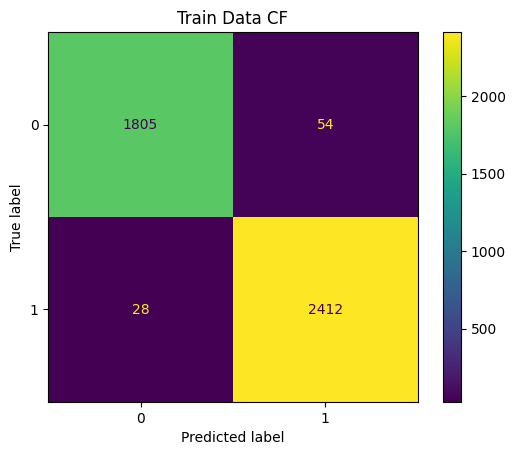

In [ ]:
# Confusion Matrix
vc_model.fit(X_train, y_train)
vc_model_pred = vc_model.predict(X_test)
vc_model_pred_train = vc_model.predict(X_train)
print("Train_Accuracy:\t", accuracy_score(y_train, vc_model_pred_train))
confusion_matrix_train = confusion_matrix(y_train, vc_model_pred_train)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train)
cm_display.plot()
plt.title('Train Data CF')
plt.plot()

Test_Accuracy:	 0.9255813953488372


[]

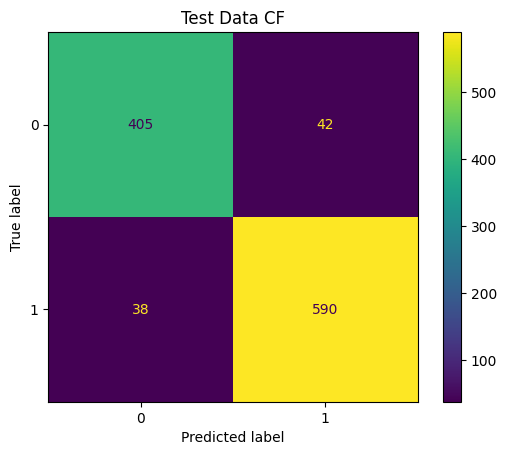

In [ ]:
confusion_matrix_test = confusion_matrix(y_test, vc_model_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test)
print("Test_Accuracy:\t", accuracy_score(y_test, vc_model_pred))
cm_display.plot()
plt.title('Test Data CF')
plt.plot()

<h3>We will use <b>LGB</b> as it most accurate and fastest algorithm among all algorithms.

<h2><b> Final Model

In [234]:
import lightgbm as lgb
final_model = lgb.LGBMClassifier(n_estimators = 100, num_leaves = 31, max_depth = 12, min_split_gain = 0.85, reg_lambda = 15, learning_rate = 0.37)
LGB_dr_result_final = cross_validation(final_model, X_dr_scaled_df.drop(['map'], axis = 1), y.iloc[:, 0], 10)
print(LGB_dr_result_final['Mean Training accuracy'], LGB_dr_result_final['Mean Training f1'], LGB_dr_result_final['Mean Validation accuracy'], LGB_dr_result_final['Mean Validation f1'])

0.9720671603111732 0.9756116465154546 0.9326376053110701 0.9411498668109924


Train_Accuracy:	 0.9723191439869737


[]

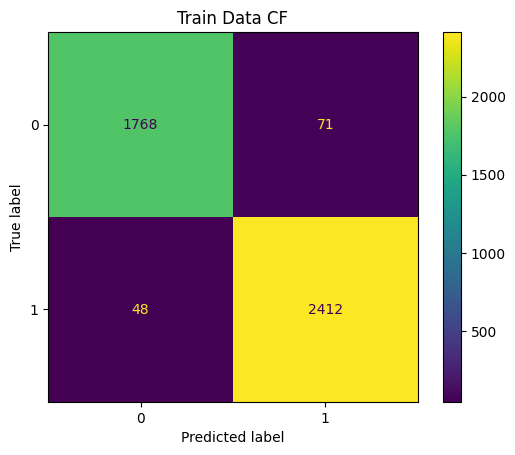

In [235]:
final_model.fit(X_train, y_train)
final_model_pred = final_model.predict(X_test)
final_model_pred_train = final_model.predict(X_train)
print("Train_Accuracy:\t", accuracy_score(y_train, final_model_pred_train))
confusion_matrix_train = confusion_matrix(y_train, final_model_pred_train)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train)
cm_display.plot()
plt.title('Train Data CF')
plt.plot()

Test_Accuracy:	 0.9330232558139535


[]

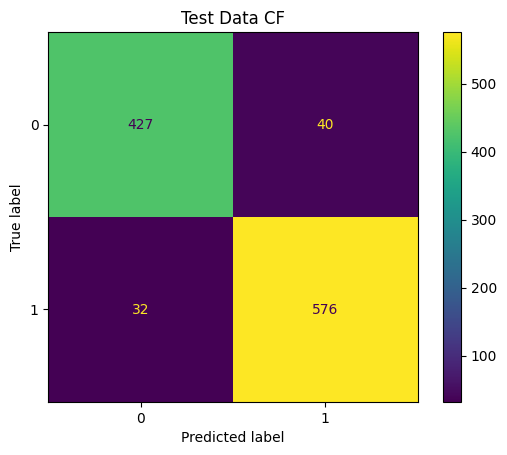

In [236]:
confusion_matrix_test = confusion_matrix(y_test, final_model_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test)
print("Test_Accuracy:\t", accuracy_score(y_test, final_model_pred))
cm_display.plot()
plt.title('Test Data CF')
plt.plot()

In [239]:
final_model._n_features

16

In [240]:
import pickle
pickle.dump(final_model, open('model_with_agent.pkl', 'wb'))

<h2><b>Prediction

<h3><b>Data collection for given input

In [57]:
import requests
from bs4 import BeautifulSoup

In [58]:
headers={'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win 64 ; x64) Apple WeKit /537.36(KHTML , like Gecko) Chrome/80.0.3987.162 Safari/537.36'}

In [72]:
def get_players_url(riot_id: list(), tagline: list(), ep = 7, act = 1):
    players_url = []
    headers={'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win 64 ; x64) Apple WeKit /537.36(KHTML , like Gecko) Chrome/80.0.3987.162 Safari/537.36'}
    for i in range(10):
        riot_id[i] = riot_id[i].replace(' ', '%20')
        url = f'https://blitz.gg/valorant/profile/{riot_id[i]}-{tagline[i]}?actName=e{ep}act{act}'
        players_url.append(url)
    return players_url

In [73]:
# given data
riot_id = ['SHORT BUS RIDER', 'curry', 'twitch ion2x', 'Roar', 'squaretale', 'nabil', 'duK', 'synapse 37', 'ShimmyXD', 'Hydroxic']
tagline = ['kit', '66666', '2009', '1234', 'NA1', 'jess', 'gamer', '9876', 'NA1', '0000']
agent = ['reyna', 'sova', 'jett', 'omen', 'cypher', 'sova', 'jett', 'breach', 'omen', 'killjoy']
map = 'Haven'
players_url = get_players_url(riot_id, tagline, 7, 1)

In [74]:
def get_match_data(plr_):
    try:
        player_stat_lst = []
        headers={'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win 64 ; x64) Apple WeKit /537.36(KHTML , like Gecko) Chrome/80.0.3987.162 Safari/537.36'}

        url = plr_
        webpage=requests.get(url ,headers=headers).text
        soup=BeautifulSoup(webpage,'lxml')
        player_stat = soup.find_all('div', class_ = 'â¡6b4dc2a9')[0].find_all('div', class_ = 'â¡196c999c')

        KD = float(player_stat[0].find_all('p', class_ = 'stat-data-point')[0].text.strip())
        Econ = float(player_stat[4].find_all('p', class_ = 'stat-data-point')[0].text.strip())
        avg_score = float(player_stat[3].find_all('p', class_ = 'stat-data-point')[0].text.strip())

        player_stat_lst.append(KD)
        player_stat_lst.append(Econ)
        player_stat_lst.append(avg_score)
        return player_stat_lst
    except:
        print('Server Not reachable at this moment. Please try again later')

In [75]:
all_plr_data = []
for i, player in enumerate(players_url):
    print(player)
    all_plr_data.append(get_match_data(player))

https://blitz.gg/valorant/profile/SHORT%20BUS%20RIDER-kit?actName=e7act1
https://blitz.gg/valorant/profile/curry-66666?actName=e7act1
https://blitz.gg/valorant/profile/twitch%20ion2x-2009?actName=e7act1
https://blitz.gg/valorant/profile/Roar-1234?actName=e7act1
https://blitz.gg/valorant/profile/squaretale-NA1?actName=e7act1
https://blitz.gg/valorant/profile/nabil-jess?actName=e7act1
https://blitz.gg/valorant/profile/duK-gamer?actName=e7act1
https://blitz.gg/valorant/profile/synapse%2037-9876?actName=e7act1
https://blitz.gg/valorant/profile/ShimmyXD-NA1?actName=e7act1
https://blitz.gg/valorant/profile/Hydroxic-0000?actName=e7act1


In [76]:
all_plr_data

[[0.97, 54.4, 218.0],
 [1.28, 65.0, 257.0],
 [1.31, 63.3, 311.0],
 [1.11, 51.9, 263.0],
 [0.98, 51.8, 196.0],
 [1.15, 572.9, 409.0],
 [1.23, 65.5, 240.0],
 [1.32, 28.0, 587.0],
 [1.14, 62.1, 226.0],
 [1.03, 494.3, 274.0]]

In [77]:
in_data = pd.DataFrame(columns = list(valo_df.columns))
in_data['map'] = [map]
for i in range(1,6):
    in_data[f'A_player_{i}_agent'] = [agent[i-1]]
    in_data[f'A_player_{i}_KD'] = all_plr_data[i-1][0]
    in_data[f'A_player_{i}_Econ'] = all_plr_data[i-1][1]
    in_data[f'A_player_{i}_avg_score'] = all_plr_data[i-1][2]

for i in range(6, 11):
    in_data[f'B_player_{5 if i%5 == 0 else i%5}_agent'] = [agent[i-1]]
    in_data[f'B_player_{5 if i%5 == 0 else i%5}_KD'] = all_plr_data[i-1][0]
    in_data[f'B_player_{5 if i%5 == 0 else i%5}_Econ'] = all_plr_data[i-1][1]
    in_data[f'B_player_{5 if i%5 == 0 else i%5}_avg_score'] = all_plr_data[i-1][2]

In [78]:
in_data

,map,A_player_1_agent,A_player_1_KD,A_player_1_Econ,A_player_1_avg_score,A_player_2_agent,A_player_2_KD,A_player_2_Econ,A_player_2_avg_score,A_player_3_agent,...,B_player_3_avg_score,B_player_4_agent,B_player_4_KD,B_player_4_Econ,B_player_4_avg_score,B_player_5_agent,B_player_5_KD,B_player_5_Econ,B_player_5_avg_score,A_outcome
0,Haven,reyna,0.97,54.4,218.0,sova,1.28,65.0,257.0,jett,...,587.0,omen,1.14,62.1,226.0,killjoy,1.03,494.3,274.0,NaN


<h3><b>Making Pipeline for data preprocessing

In [217]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
set_config(display = 'diagram')
pipe = Pipeline([
    ('trf1', transformer_1),
    ('trf2', transformer_2),
    ('trf3', transformer_3)
])

In [218]:
pipe.fit(valo_df.drop(['A_outcome'], axis = 1))

Pipeline(steps=[('trf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf1',
                                                  OrdinalEncoder(categories=[['Split',
                                                                              'Pearl',
                                                                              'Lotus',
                                                                              'Haven',
                                                                              'Fracture',
                                                                              'Ascent',
                                                                              'Bind',
                                                                              'Icebox']]),
                                                  [0]),
                                                 ('trf3',
                                                  OrdinalEncoder(categories=[['jett',
                                                                              'killjoy',
                                                                              'reyna',
                                                                              'omen',
                                                                              'raze',
                                                                              'sova',
                                                                              'skye',
                                                                              'cypher',
                                                                              'brimstone',
                                                                              'astra',
                                                                              'breach',
                                                                              'chamber',
                                                                              'sage',
                                                                              'fade',
                                                                              'viper'...
                                                  [12, 15, 18, 21, 24]),
                                                 ('pca3',
                                                  PCA(copy=False,
                                                      n_components=1),
                                                  [13, 16, 19, 22, 25]),
                                                 ('pca4',
                                                  PCA(copy=False,
                                                      n_components=1),
                                                  [6, 7, 8, 9, 10]),
                                                 ('pca5',
                                                  PCA(copy=False,
                                                      n_components=1),
                                                  [27, 30, 33, 36, 39]),
                                                 ('pca6',
                                                  PCA(copy=False,
                                                      n_components=1),
                                                  [28, 31, 34, 37, 40])])),
                ('trf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('min_max_scalar',
                                                  MinMaxScaler(),
                                                  slice(0, 18, None))]))])

In [81]:
X_dr_scaled_df.shape

(5374, 17)

In [82]:
X_input = pipe.transform(in_data.iloc[:, :-1])

In [83]:
X_input = pd.DataFrame(X_input, columns = list(X_dr_scaled_df.columns))

In [179]:
final_model.predict_proba(X_input.drop(['map'], axis = 1))

array([[0.81107795, 0.18892205]])

In [180]:
final_model_pred = final_model.predict(X_input.drop(['map'], axis = 1))

In [181]:
if(final_model_pred[0]==1):
    print('Victory')
else:
    print('Defeat')

Defeat


In [219]:
pickle.dump(pipe, open('pipe_with_agent.pkl', 'wb'))

<h1><b>model with agent + model without agent

In [416]:
class Valo_prediction:

    file = open('/content/model_with_agent.pkl', 'rb')
    model_with_agent = pickle.load(file)
    file.close()

    file = open('/content/model_without_agent.pkl', 'rb')
    model_without_agent = pickle.load(file)
    file.close()

    file = open('/content/pipe_with_agent.pkl', 'rb')
    pipe_with_agent = pickle.load(file)
    file.close()

    file = open('/content/scaler_no_agent', 'rb')
    scaler_no_agent = pickle.load(file)
    file.close()


    def __init__(self):
        self.X_input = None
        self.X_input_columns = ['A_agent_dr', 'A_Econ_dr', 'A_avg_score_dr', 'B_agent_dr', 'B_Econ_dr', 'B_avg_score_dr', 'map', 'A_player_1_KD', 'A_player_2_KD', 'A_player_3_KD', 'A_player_4_KD', 'A_player_5_KD', 'B_player_1_KD', 'B_player_2_KD', 'B_player_3_KD', 'B_player_4_KD', 'B_player_5_KD']

    def fit(self, X_main_data, y_main_data):
        self.X_main_input = self.pipe_with_agent.transform(X_main_data)
        self.X_main_input = pd.DataFrame(self.X_main_input, columns = self.X_input_columns)
        self.model_with_agent.fit(self.X_main_input.drop(['map'], axis = 1), y_main_data)
        self.model_without_agent.fit(self.scaler_no_agent.transform(X_main_data.drop(valo_agent_col+['map'], axis = 1)), y_main_data)

    def predict(self, input_data):
        self.X_input = self.pipe_with_agent.transform(input_data)
        self.X_input = pd.DataFrame(self.X_input, columns = self.X_input_columns)
        return np.argmax((self.model_with_agent.predict_proba(self.X_input.drop(['map'], axis = 1)) + self.model_without_agent.predict_proba(self.scaler_no_agent.transform(input_data.drop(valo_agent_col+['map'], axis = 1))))/2, axis = 1)

In [417]:
moddeell = Valo_prediction()

In [418]:
X_train, X_test, y_train, y_test = train_test_split(valo_df.drop(['A_outcome'], axis = 1), out_transform.fit_transform(valo_df[['A_outcome']]), test_size=0.2)
moddeell.fit(X_train, y_train.ravel())
predict_ans_com = moddeell.predict(X_test)
predict_ans_com_train = moddeell.predict(X_train)
print(accuracy_score(y_test, predict_ans_com))
print(accuracy_score(y_train, predict_ans_com_train))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.9292196007259528
0.9666212534059946


Train_Accuracy:	 0.9666212534059946


[]

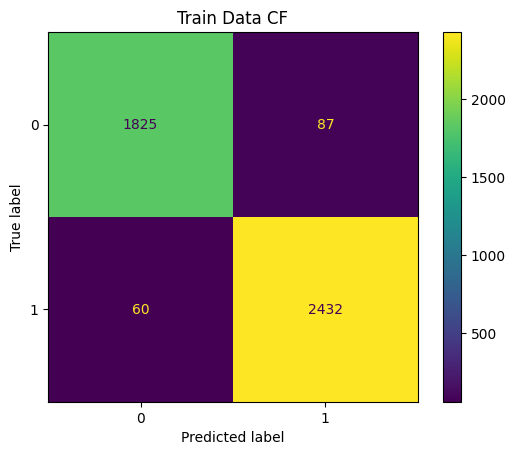

In [419]:
moddeell.fit(X_train, y_train.ravel())
moddeell_pred = moddeell.predict(X_test)
moddeell_pred_train = moddeell.predict(X_train)
print("Train_Accuracy:\t", accuracy_score(y_train, moddeell_pred_train))
confusion_matrix_train = confusion_matrix(y_train, moddeell_pred_train)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_train)
cm_display.plot()
plt.title('Train Data CF')
plt.plot()

Test_Accuracy:	 0.9292196007259528


[]

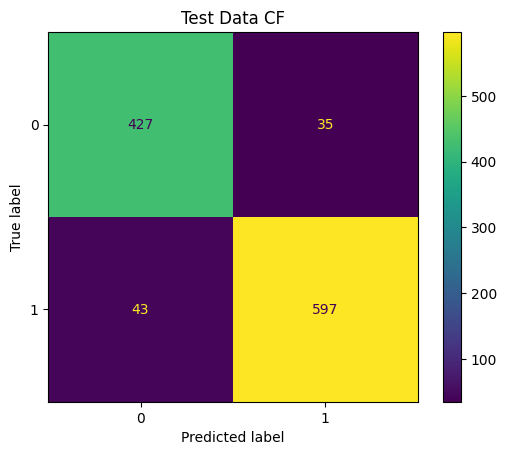

In [421]:
confusion_matrix_test = confusion_matrix(y_test, moddeell_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_test)
print("Test_Accuracy:\t", accuracy_score(y_test, moddeell_pred))
cm_display.plot()
plt.title('Test Data CF')
plt.plot()

<h2>Conclusion

On combining both the model (Model Considering Agent + Model Not Considering Agents), we got 92.92% accuracy on our test data compaired to 94.28% accuracy while using only Model Not Considering Agents. Hence we conclude that the Model Not Considering Agents will be our final model for deployment purpose for now.